In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statistics 
import sklearn.metrics as metrics
import keras

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,chi2

from sklearn.linear_model          import LogisticRegression, SGDClassifier
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.gaussian_process      import GaussianProcessClassifier
from sklearn.svm                   import SVC
from sklearn.naive_bayes           import GaussianNB
from sklearn.tree                  import DecisionTreeClassifier
from sklearn.ensemble              import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.utils import to_categorical
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.callbacks import History 
from keras.utils import plot_model
from keras.optimizers import SGD


import seaborn as sns
%matplotlib inline


import warnings
warnings.filterwarnings("ignore")

season_stats = pd.read_csv('nba-players-stats/Seasons_Stats.csv', index_col=0)

Using TensorFlow backend.


In [2]:
## Data Filter / Data Clean / Hall of Fame column

## Players past 1980 and minimum number of games > 30 are used for evaluation
season_stats_filtered = season_stats.copy()
season_stats_filtered = season_stats.query('Year >= 1980')
season_stats_filtered = season_stats_filtered.query('G >= 30')

## Removed columns with no predictive power
season_stats_filtered.drop(['GS','blanl','blank2','blank2','Age', 'Tm'], axis=1, inplace=True)

## All the null values are handled - these values are null because there is 0 sample for the percentiles - thus 0.
null_data = season_stats_filtered[season_stats_filtered.isnull().any(axis=1)]
season_stats_filtered.fillna(0, inplace=True)

##Make column where each players are hall of famer or not##
hof_container = season_stats_filtered.copy()
hof_container['Player'] = hof_container['Player'].str.replace("*", "_hof")
hof_container = hof_container[hof_container['Player'].str.contains("_hof")]['Player'].str.replace("_hof", "*").unique()
season_stats_filtered['isHoF'] = ''
season_stats_filtered['isHoF'] = np.where(season_stats_filtered['Player'].isin(hof_container), 1,0)
season_stats_filtered['Player'] = season_stats_filtered['Player'].str.replace("*", "")

## Remove correlating features
independent_features = ['Player', 'Pos', 'G','MP', '2P', '2P%', '3P', '3P%', 'FT', 'FT%', 'USG%', 'ORB', 'DRB', 'AST', 'AST%', 'STL', 'STL%', 'BLK', 'BLK%', 'TOV', 'PTS', 'isHoF']
season_stats_filtered = season_stats_filtered[independent_features]

## Divide each countable features by G and remove G
countable_columns = ['MP', '2P','3P', 'FT','ORB','DRB','AST','STL','BLK','TOV','PTS']
season_stats_filtered[countable_columns]  = season_stats_filtered[countable_columns] .div(season_stats_filtered['G'].values,axis=0)

season_stats_filtered.rename(columns={'MP':'MP/G','2P':'2P/G','3P':'3P/G','FT':'FT/G'
                                     ,'ORB':'ORB/G','DRB':'DRB/G','AST':'AST/G','STL':'STL/G'
                                     ,'BLK':'BLK/G','TOV':'TOV/G','PTS':'PTS/G'}, inplace=True)
season_stats_filtered.drop(['G'], axis=1, inplace=True)

## Get Average of all player's career
career_df = season_stats_filtered.groupby(['Player']).mean().reset_index().round(2)




In [3]:
## Split to train and test sets

X = career_df.drop(['Player','isHoF'],axis=1)
y = career_df.isHoF

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=0, stratify =y)

In [4]:
## Creating temporary df for plotting

df_plot = pd.DataFrame(data=X_train, columns=X_train.columns)
df_plot['isHoF'] = y_train

df_plot_hof  = df_plot[df_plot['isHoF'] == 1]
df_plot_nhof  = df_plot[df_plot['isHoF'] == 0]



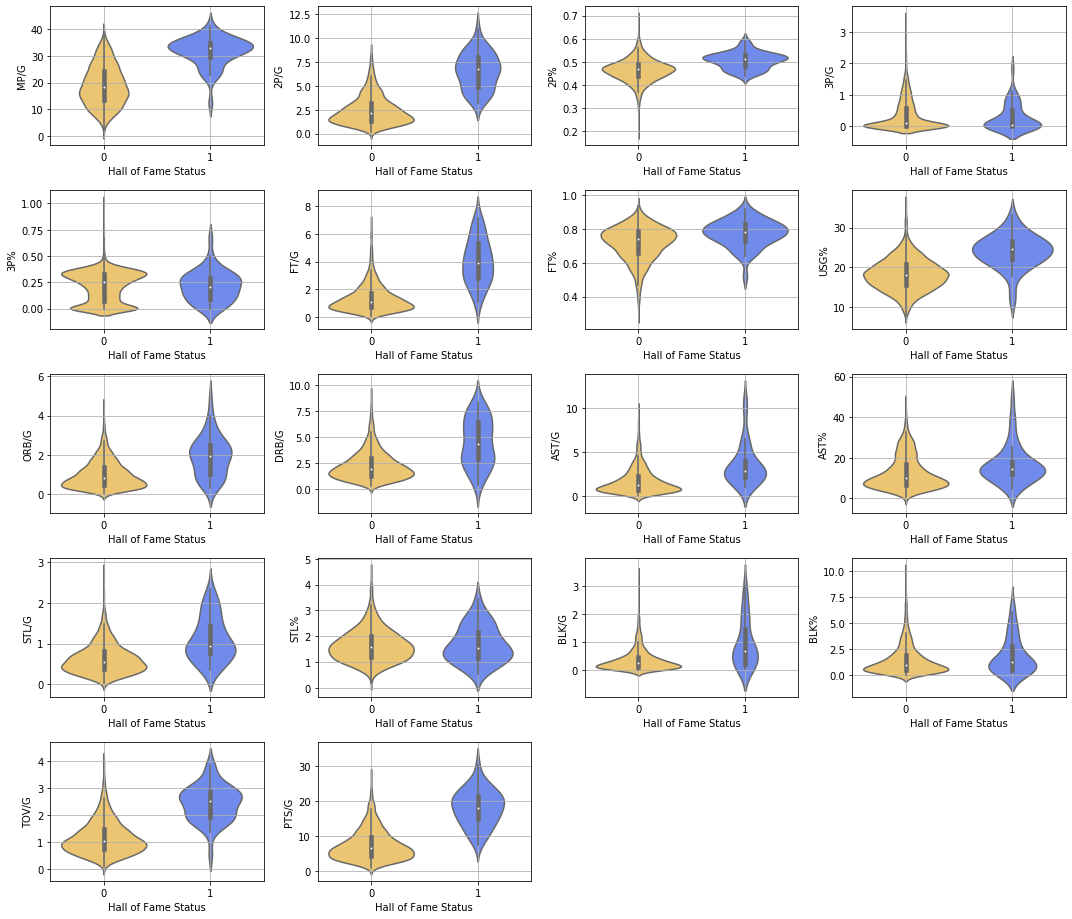

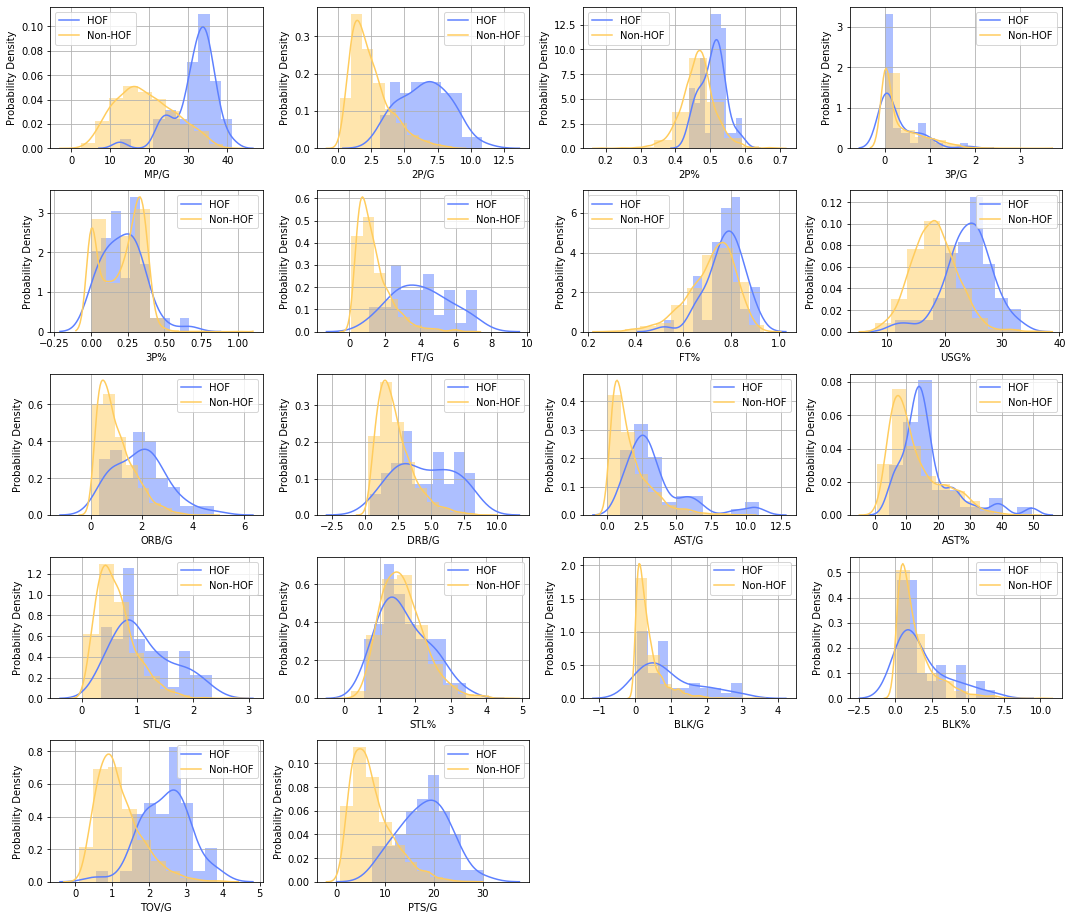

In [5]:
## Plotting EDA
plt.figure(figsize=(15, 15))

for i, feature in enumerate(df_plot.columns[:-1]):

    plt.subplot(6, 4, i+1)
    sns.violinplot(x="isHoF", y=feature, data=df_plot, palette={0: "#ffcc5d", 1: "#5d80ff"})
    plt.xlabel('Hall of Fame Status')
    plt.ylabel(feature)
    plt.grid(True)
    plt.tight_layout()

plt.figure(figsize=(15, 15))


for i, feature in enumerate(df_plot.columns[:-1]):

    plt.subplot(6, 4, i+1)
    sns.distplot(df_plot_hof[feature], bins=10, color="#5d80ff",
                  kde_kws={"label": "HOF"},
                  hist_kws={"linewidth": 1,
                            "alpha": 0.5,"color": "#5d80ff"})
    sns.distplot(df_plot_nhof[feature], bins=10, color="#ffcc5d",
                  kde_kws={"label": "Non-HOF"},
                  hist_kws={"linewidth": 1,
                            "alpha": 0.5,"color": "#ffcc5d"})
    
    plt.xlabel(feature)
    plt.ylabel('Probability Density')
    plt.grid(True)
    plt.tight_layout()


Finding:
    - Although pre-feature selection is implemented, there may be more features irrelevant to the model
    - Hall of Famers had greater volume and efficiency in scoring categories except 3PT categories
    - Hall of Famers had greater volume and efficiency in rebounding and assist categories
    - Hall of Famers had greater volume but Simillar efficiency in defensive categories
    - Hall of Famers had higher turnover/game than average players. This was expected as they had higher usage
    
Hypothesis:
    - 3PT, 3PT%, STL%, BLK% may not have much impact on isHoF category
    - Perform Null Hypothesis Testing by backward elimination and correlation matrix
    - Combine result of these fields to find out fields that are not relevant for analysis

In [6]:
#Backward Elimination
cols = list(X.columns)
pmax = 1
elim_feat_from_p_val_backward_elim = []
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()

    if(pmax>0.05):
        cols.remove(feature_with_p_max)
        elim_feat_from_p_val_backward_elim.append(feature_with_p_max)
    else:
        break

elim_feat_from_p_val_backward_elim

elim_feat_from_corr = df_plot.corr()['isHoF'].abs().sort_values()
elim_feat_from_corr = list(elim_feat_from_corr[elim_feat_from_corr < 0.25].keys())

elim_fields = list(set(elim_feat_from_p_val_backward_elim).intersection(set(elim_feat_from_corr)))

print("Features further that can be eliminated are", elim_fields)

Features further that can be eliminated are ['STL%', 'DRB/G', 'ORB/G', 'FT%', 'STL/G']


In [7]:
## Field elimination
X_train.drop(elim_fields, axis=1, inplace=True)
X_test.drop(elim_fields, axis=1, inplace=True)
career_df.drop(elim_fields, axis=1, inplace=True)

In [22]:
X = career_df.drop(['Player','isHoF'],axis=1)
y = career_df.isHoF

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25, random_state=0, stratify =y)

In [23]:
X_scaler = StandardScaler(with_mean=True, with_std=True) 
X_train_scaled = X_scaler.fit_transform(X_train) 
X_test_scaled  = X_scaler.transform(X_test)

In [37]:
models = []

def estimator_dict(name, estimator):
    model = {'name':name, 'estimator':estimator}
    return model

models.append(estimator_dict('K-Nearest Neighbours Classifier', KNeighborsClassifier(n_neighbors=3, weights='uniform')))
models.append(estimator_dict('Logistic Regression Classifier', LogisticRegression()))
models.append(estimator_dict('SVM Classifier', SVC(probability=True)))
models.append(estimator_dict('Stochastic Gradient Descent Classifier', SGDClassifier(loss="log", random_state=50)))
models.append(estimator_dict('Gaussian Process Classifier', GaussianProcessClassifier(random_state=50)))
models.append(estimator_dict('Gaussian Naive Bayes Classifier', GaussianNB()))
models.append(estimator_dict('Decision Tree Classifier', DecisionTreeClassifier(max_depth=None, max_features='auto', random_state=50)))
models.append(estimator_dict('Random Forest Classifier', RandomForestClassifier(n_estimators=200, max_depth=None, max_features='auto', random_state=50)))
## Neural Network

In [38]:
## Way to opt hyperparam : GridSearchCV, randomSearch, Bayesian Optimization

## ROC/AUC for basic default models
## Hyperparam Optimizion
## re-do ROC/AUC show improvement
## ---- END OF PART 1 --
## Investigate failure caes whether false positive or false negative and explain
## Implement the theory - re-design model
## re-run model

## Dataset of "test test" --> see result
## Try to find trend for false +ves/ False -ves


model_vals = []

for model_dict in models:
    
    name = model_dict['name']
    estimator = model_dict['estimator']

    print("doing estimation on...", model_dict['name'])

    model = estimator.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    acc_score = accuracy_score(y_pred, y_test)
    report = classification_report(y_pred, y_test)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Vary thresholds by 0.05 from 0.05 to 0.95
    thresholds = np.arange(0.05, 1, 0.05)
    #print("############", thresholds)
    precisions = list()
    recalls = list()
    f1_list = list()

    for threshold in thresholds:
        y_proba = model.predict_proba(X_test_scaled)[:,1]
        # Apply threshold
        y_threshold = np.where(y_proba > threshold, 1, 0)
        # Calculate precision and recall
        precision = precision_score(y_test, y_threshold)
        recall = recall_score(y_test, y_threshold)
        f1 = f1_score(y_test, y_pred)
        # Append to list
        
        precisions.append(precision)
        recalls.append(recall)
        f1_list.append(f1)
    
    model_val = {"name": name, "precision_mean" : statistics.mean(precisions), 
                 "recall_mean" : statistics.mean(recalls),
                 "f1_mean":statistics.mean(f1_list), "precision_std": statistics.stdev(precisions),
                 "recall_std" : statistics.stdev(recalls), 'accuracy_score':acc_score}
    
    model_vals.append(model_val)

        
df_sum = pd.DataFrame.from_dict(model_vals)
display(df_sum)    

doing estimation on... K-Nearest Neighbours Classifier
doing estimation on... Logistic Regression Classifier
doing estimation on... SVM Classifier
doing estimation on... Stochastic Gradient Descent Classifier
doing estimation on... Gaussian Process Classifier
doing estimation on... Gaussian Naive Bayes Classifier
doing estimation on... Decision Tree Classifier
doing estimation on... Random Forest Classifier


,name,precision_mean,recall_mean,f1_mean,precision_std,recall_std,accuracy_score
0,K-Nearest Neighbours Classifier,0.431505,0.154135,0.235294,0.341338,0.124319,0.975881
1,Logistic Regression Classifier,0.595344,0.251880,0.400000,0.301072,0.184993,0.977737
2,SVM Classifier,0.635407,0.146617,0.235294,0.184418,0.016387,0.975881
3,Stochastic Gradient Descent Classifier,0.664172,0.293233,0.380952,0.265109,0.106199,0.975881
4,Gaussian Process Classifier,0.067378,0.364662,0.222222,0.116857,0.427177,0.974026
5,Gaussian Naive Bayes Classifier,0.172772,0.804511,0.282051,0.018277,0.040139,0.896104
6,Decision Tree Classifier,0.500000,0.214286,0.300000,0.000000,0.000000,0.974026
7,Random Forest Classifier,0.474831,0.191729,0.235294,0.346861,0.197852,0.975881


In [32]:
from sklearn.model_selection import GridSearchCV

k_range = list(range(1, 31))
knn = KNeighborsClassifier(n_neighbors=all)
weight_options = ['uniform', 'distance']
param_grid = dict(n_neighbors=k_range, weights=weight_options)
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(X_train, y_train)
grid.best_params_

{'n_neighbors': 6, 'weights': 'distance'}

Finding:
    - Despite high accuracy, none of these models are able to achieve satisfactory precision and recalls
    - Hyperparameter optimization is required to improve on the model

Hypothesis:
    - GridSearch will be performed to find hyperparameters
    - These parameters will further be implemented and further analysis will be shown

In [12]:
n_cols = X_train.shape[1]
y_train_nn = to_categorical(y_train, 2)

In [13]:
hist = History()

model = Sequential()


model.add(Dense(300, activation='relu', input_dim = n_cols))
model.add(Dense(300, activation='relu'))
model.add(Dense(300, activation='relu'))
model.add(Dense(300, activation='relu'))

model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])


model.fit(X_train_scaled, y_train_nn, epochs = 40, validation_split = .1, callbacks = [hist])

y_pred =  model.predict(X_test_scaled)
y_pred = np.round(y_pred[:,1])


print(metrics.accuracy_score(y_pred,y_test))

print("## actual y", y_test.sum())
print("## y_pred", y_pred.sum())

# ROc curve
# auc curve
# pr vs. recall 
# F1 Curve

Train on 1260 samples, validate on 141 samples
Epoch 1/40
1260/1260 [==============================] - 1s 435us/step - loss: 0.1636 - accuracy: 0.9548 - val_loss: 0.0815 - val_accuracy: 0.9716
Epoch 2/40
1260/1260 [==============================] - 0s 182us/step - loss: 0.0912 - accuracy: 0.9746 - val_loss: 0.0962 - val_accuracy: 0.9716
Epoch 3/40
1260/1260 [==============================] - 0s 195us/step - loss: 0.0756 - accuracy: 0.9746 - val_loss: 0.1332 - val_accuracy: 0.9716
Epoch 4/40
1260/1260 [==============================] - 0s 177us/step - loss: 0.0682 - accuracy: 0.9746 - val_loss: 0.0939 - val_accuracy: 0.9716
Epoch 5/40
1260/1260 [==============================] - 0s 250us/step - loss: 0.0617 - accuracy: 0.9746 - val_loss: 0.0876 - val_accuracy: 0.9716
Epoch 6/40
1260/1260 [==============================] - 0s 223us/step - loss: 0.0635 - accuracy: 0.9754 - val_loss: 0.0894 - val_accuracy: 0.9716
Epoch 7/40
1260/1260 [==============================] - 0s 189us/step - loss: